# Neural Processes
Author: Jin Yeom (jinyeom@utexas.edu)

## Contents
- [Introduction](#Introduction)
- [1-D Regression](#1-D-Regression)
- [Implementation](#Implementation)
- [Experiments](#Experiments)

In [41]:
import collections

# NOTE: this notebook requires PyTorch>=1.0 for Cholesky computation
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [50]:
%matplotlib inline
sns.set()

## Introduction

[Neural Processes](https://arxiv.org/abs/1807.01622) (NPs) are a novel class of function approximation  methods that was presented by DeepMind, just few months back in July, 2018. Generalizing from their previous work, [Conditional Neural Processes](https://arxiv.org/abs/1807.01613) (CNPs), NPs bring benefits of neural networks and Gaussian processes (GPs), i.e., while being able to estimate the distribution of functions and adapt rapidly to new observations like GPs, they are computationally efficient during training like neural networks.

To borrow from DeepMind's [CNP notebook](https://github.com/deepmind/conditional-neural-process/blob/master/conditional_neural_process.ipynb),

> [Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were introduced as a continuation of [Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/) (GQN) to extend its training regime to tasks beyond scene rendering, e.g. to regression and classification.
>
> In contrast to most standard neural networks, CNPs learn to approximate a distribution over functions rather than approximating just a single function. As a result, at test time CNPs are flexible and can approximate any function from this distribution when provided with a handful of observations. In addition, they learn to estimate the uncertainty of their prediction from the dataset and as the number of observations is increased this uncertainty reduces and the accuracy of their prediction increases.

NPs are simply an extension of CNPs with latent variables that allow global sampling, hence are able to produce different function samples from the same observed context data.

NPs consist of three main components:
* An **encoder** $h$ which encodes *pairs* of $(x_i, y_i)$ context values to their representations $r_i$ 
* An **aggregator** $a$ that summarizes encoded context values ($r_1$, $r_2$, ..., $r_n$) to a representation $r$
* A **condition decoder** $g$ that takes a sampled $z$ and the new target locations $x_T$ and predicts $y_T$

## 1-D Regression

Since the purpose of this notebook is to explore the basics of NPs, we'll aim to reproduce the 1-D regression result by Garnelo et al. Once again, this data generaion code is adopted from DeepMind's CNP notebook, to be used with PyTorch.

In [105]:
# The NP takes as input a `CNPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tesor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration
NPRegressionDescription = collections.namedtuple(
        "NPRegressionDescription",
        ("query", "target_y", "num_total_points", "num_context_points"))


class GPCurvesReader(object):
    """Generates curves using a Gaussian Process (GP).

    Supports vector inputs (x) and vector outputs (y). Kernel is
    mean-squared exponential, using the x-value l2 coordinate distance scaled by
    some factor chosen randomly in a range. Outputs are independent gaussian
    processes.
    """

    def __init__(self, batch_size, max_num_context, x_size=1, y_size=1,
            l1_scale=0.4, sigma_scale=1.0, testing=False):
        """Creates a regression dataset of functions sampled from a GP.

        Args:
            batch_size: An integer.
            max_num_context: The max number of observations in the context.
            x_size: Integer >= 1 for length of "x values" vector.
            y_size: Integer >= 1 for length of "y values" vector.
            l1_scale: Float; typical scale for kernel distance function.
            sigma_scale: Float; typical scale for variance.
            testing: Boolean that indicates whether we are testing. If so there are
                    more targets for visualization.
        """
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self._l1_scale = l1_scale
        self._sigma_scale = sigma_scale
        self._testing = testing

    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Applies the Gaussian kernel to generate curve data.

        Args:
            xdata: Tensor with shape `[batch_size, num_total_points, x_size]` with
                    the values of the x-axis data.
            l1: Tensor with shape `[batch_size, y_size, x_size]`, the scale
                    parameter of the Gaussian kernel.
            sigma_f: Float tensor with shape `[batch_size, y_size]`; the magnitude
                    of the std.
            sigma_noise: Float, std of the noise that we add for stability.

        Returns:
            The kernel, a float tensor with shape
            `[batch_size, y_size, num_total_points, num_total_points]`.
        """
        num_total_points = xdata.shape[1]

        # Expand and take the difference
        xdata1 = xdata.unsqueeze(1)  # [B, 1, num_total_points, x_size]
        xdata2 = xdata.unsqueeze(2)  # [B, num_total_points, 1, x_size]
        diff = xdata1 - xdata2  # [B, num_total_poinst, num_total_points, x_size]

        # [B, y_size, num_total_points, num_total_points, x_size]
        norm = (diff[:, None, :, :, :] / l1[:, :, None, None, :])**2
        norm = torch.sum(norm, -1)  # [B, data_size, num_total_points, num_total_points]

        # [B, y_size, num_total_points, num_total_points]
        kernel = (sigma_f**2)[:, :, None, None] * torch.exp(-0.5 * norm)

        # Add some noise to the diagonal to make the cholesky work.
        kernel += (sigma_noise**2) * torch.eye(num_total_points)

        return kernel

    def generate_curves(self):
        """Builds the op delivering the data.

        Generated functions are `float32` with x values between -2 and 2.
    
        Returns:
            A `NPRegressionDescription` namedtuple.
        """
        num_context = np.random.randint(3, self._max_num_context)

        # If we are testing we want to have more targets and have them evenly
        # distributed in order to plot the function.
        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.arange(-2.0, 2.0, 0.01).unsqueeze(0).repeat(self._batch_size, 1)
            x_values = x_values.unsqueeze(-1)
            
        # During training the number of target points and their x-positions are
        # selected at random
        else:
            num_target = np.random.randint(2, self._max_num_context)
            num_total_points = num_context + num_target
            x_values = 4.0 * torch.rand(self._batch_size, num_total_points, self._x_size) - 2.0

        # Set kernel parameters
        l1 = torch.ones(self._batch_size, self._y_size, self._x_size) * self._l1_scale
        sigma_f = torch.ones(self._batch_size, self._y_size) * self._sigma_scale

        # Pass the x_values through the Gaussian kernel
        # [batch_size, y_size, num_total_points, num_total_points]
        kernel = self._gaussian_kernel(x_values, l1, sigma_f)
        
        # Calculate Cholesky, using double precision for better stability:
        cholesky = torch.cholesky(kernel.double()).float()

        # Sample a curve
        # [batch_size, y_size, num_total_points, 1]
        y_values = torch.matmul(cholesky, torch.randn(self._batch_size, self._y_size, num_total_points, 1))

        # [batch_size, num_total_points, y_size]
        y_values = y_values.squeeze(3).permute(0, 2, 1)

        if self._testing:
            # Select the targets
            target_x = x_values
            target_y = y_values

            # Select the observations
            idx = torch.randperm(num_target)
            context_x = torch.index_select(x_values, 1, idx[:num_context])
            context_y = torch.index_select(y_values, 1, idx[:num_context])

        else:
            # Select the targets which will consist of the context points as well as
            # some new target points
            target_x = x_values[:, :num_target + num_context, :]
            target_y = y_values[:, :num_target + num_context, :]

            # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)

        return NPRegressionDescription(
                query=query, 
                target_y=target_y,
                num_total_points=target_x.shape[1], 
                num_context_points=num_context)

In [102]:
# Train dataset
dataset_train = GPCurvesReader(batch_size=64, max_num_context=10)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = GPCurvesReader(batch_size=1, max_num_context=10, testing=True)
data_test = dataset_test.generate_curves()

In [99]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y=None, var=None):
    """Plots the predicted mean and variance and the context points.
  
    Args: 
        target_x: An array of shape batchsize x number_targets x 1 that contains the
                x values of the target points.
        target_y: An array of shape batchsize x number_targets x 1 that contains the
                y values of the target points.
        context_x: An array of shape batchsize x number_context x 1 that contains 
                the x values of the context points.
        context_y: An array of shape batchsize x number_context x 1 that contains 
                the y values of the context points.
        pred_y: An array of shape batchsize x number_targets x 1  that contains the
                predicted means of the y values at the target points in target_x.
        pred_y: An array of shape batchsize x number_targets x 1  that contains the
                predicted variance of the y values at the target points in target_x.
    """
    # Plot everything
    plt.plot(target_x[0], target_y[0], ':', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'o', markersize=10)
    
    if pred_y is not None and var is not None:
        plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
        plt.fill_between(
                target_x[0, :, 0],
                pred_y[0, :, 0] - var[0, :, 0],
                pred_y[0, :, 0] + var[0, :, 0],
                alpha=0.2,
                facecolor='#65c9f7',
                interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid(False)
    plt.show()

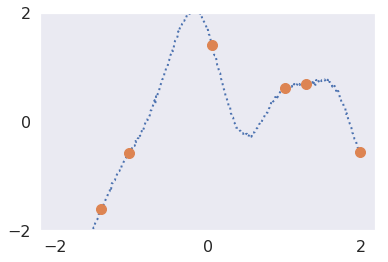

In [104]:
((context_x, context_y), target_x), target_y = data_test.query, data_test.target_y
plot_functions(target_x.numpy(), target_y.numpy(), context_x.numpy(), context_y.numpy())

## Implementation

### Encoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, cx_size, cy_size, repr_size):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(cx_size + cy_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, repr_size)
        
    def forward(self, context_x, context_y):
        input_ = torch.cat((context_x, context_y), dim=-1)
        input_ = F.relu(self.fc1(input_), inplace=True)
        input_ = F.relu(self.fc2(input_), inplace=True)
        input_ = F.relu(self.fc3(input_), inplace=True)
        repr_ = self.fc4(input_) # representation
        # TODO: return the aggregated 

### Conditional decoder

In [6]:
class ConditionalDecoder(nn.Module):
    def __init__(self, tx_size, repr_size):
        super(ConditionalDecoder, self).__init__()
        
    def forward(self, input_):
        raise NotImplementedError

## Experiments